In [1]:
import glob
import os
import random

import numpy as np

from matplotlib import pyplot as plt
from predictingcontactmaps.Utils.KerasGenerator import Voxel_to_Contact_Generator

In [2]:
#update params to reflect constructor for Voxel_to_Contact_Generator
params = {'dim': (32,32,32),
            'batch_size': 3,
            'n_channels': 8,
            'shuffle': True,
            'margin': 1,
            'voxel_size': 2,
            'n_augmentations': 3,
            'augment': False}

#build list [[antibody, antigen, full complex], [antibody, antigen, full complex], ...]
ab_ag_files = []

antibodies = glob.glob("../Data/split_Ab_Ag_size_filtered/*Ab.pdb")
for ab in antibodies:
    ag = ab.replace('_Ab.pdb','_Ag.pdb')
    both = ab.replace('_Ab.pdb','.pdb')
    both = both.replace('split_Ab_Ag_size_filtered','merged_Ab_Ag')
    ab_ag_files.append([ab, ag, both])

partition = {}

partition.update({'debug': ab_ag_files[:1]})
print(partition.values())

#Generators
training_generator = Voxel_to_Contact_Generator(file_list=partition['debug'], **params)

data = training_generator.__getitem__(0)

dict_values([[['../Data/split_Ab_Ag_size_filtered/1YJD_1_Ab.pdb', '../Data/split_Ab_Ag_size_filtered/1YJD_1_Ag.pdb', '../Data/merged_Ab_Ag/1YJD_1.pdb']]])
Block 1 took 0 seconds
Generating a batch of data took 1 seconds


In [3]:
training_generator.__len__()

1

In [4]:
data = training_generator.__getitem__(0)

Generating a batch of data took 0 seconds


In [6]:
data[0][1].sum()

729.0

In [7]:
data[0][0].sum()

1350.0

<function matplotlib.pyplot.show(*args, **kw)>

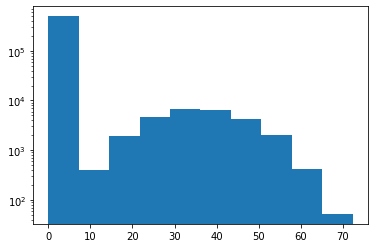

In [8]:
y = data[1][0].flatten()
plt.hist(y)
plt.yscale('log')
plt.show

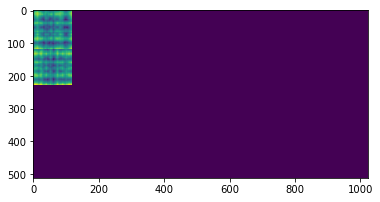

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(data[1][0])
plt.show()

In [129]:
import pandas as pd

from plotly import offline as plotly_offline
from plotly.subplots import make_subplots
from plotly import graph_objs
import matplotlib.cm
viridis_cmap = matplotlib.cm.get_cmap('viridis')

def plot_voxel_grid(data, index, gaussian = None, channels = ['CA','C', 'H', 'O', 'N', 'P', 'S','Other']):
    Ab = data[0][index]
    Ag = data[1][index]
    
    fig = make_subplots(rows=1, cols=2, specs = [[{'type' : 'Scatter3d'}, {'type' : 'Scatter3d'}]],\
                       subplot_titles=('Antibody', 'Antigen'))
    
    #Ab
    Ab_figure_traces = []  
    atom_size = 10

    atom_type_indices = {}
    coordinates = []
    for atom_type in channels:
        atom_type_indices[atom_type] = []
    
    atom_index = 0
    
    for x_index, x in enumerate(Ab):
        for y_index, y in enumerate(x):
            for z_index, atom_features in enumerate(y):
                if len(atom_features.nonzero()[0]) == 0:
                    continue
                    
                coordinates.append([x_index, y_index, z_index])
                atom_type_feature_vector = atom_features[0:len(channels)]
                atom_type_index = np.nonzero(atom_type_feature_vector)[0][0]
                atom_type = channels[atom_type_index]

                atom_type_indices[atom_type].append(atom_index)
                atom_index += 1
                
    coordinates = np.array(coordinates)        

    color_values = np.round(np.linspace(0, 1, len(channels)) * 255)
        
    for atom_type, atom_indices in sorted(atom_type_indices.items()):
        
        if len(atom_indices) == 0:
            continue

        atom_type_index = channels.index(atom_type)
        color_value = matplotlib.colors.Normalize(vmin=0, vmax=255)(color_values[atom_type_index])
        color_value = np.array(matplotlib.colors.colorConverter.to_rgb(viridis_cmap(color_value)))
        color_value *= 255
        color_value = color_value.round()
        color_string = "rgb(%i, %i, %i)" % ((int(color_value[0]), int(color_value[1]), int(color_value[2])))

        atom_scatter = graph_objs.Scatter3d(
            x=coordinates[atom_indices,0],
            y=coordinates[atom_indices,1],
            z=coordinates[atom_indices,2],
            mode='markers',
            name=atom_type,
            marker=dict(
                size=atom_size,
                color=color_string,
                symbol="square"
            ),
            text=atom_indices,
            legendgroup = atom_type
        )

        Ab_figure_traces.append(atom_scatter)
        
    #Ag
    Ag_figure_traces = []  
    atom_size = 10

    atom_type_indices = {}
    coordinates = []
    for atom_type in channels:
        atom_type_indices[atom_type] = []
    
    atom_index = 0
    
    coordinates = []    
    for x_index, x in enumerate(Ag):
        for y_index, y in enumerate(x):
            for z_index, atom_features in enumerate(y):
                if len(atom_features.nonzero()[0]) == 0:
                    continue
                    
                coordinates.append([x_index, y_index, z_index])
                atom_type_feature_vector = atom_features[0:len(channels)]
                atom_type_index = np.nonzero(atom_type_feature_vector)[0][0]
                atom_type = channels[atom_type_index]

                atom_type_indices[atom_type].append(atom_index)
                atom_index += 1
                
    coordinates = np.array(coordinates)        

    color_values = np.round(np.linspace(0, 1, len(channels)) * 255)
        
    for atom_type, atom_indices in sorted(atom_type_indices.items()):
        
        if len(atom_indices) == 0:
            continue

        atom_type_index = channels.index(atom_type)
        color_value = matplotlib.colors.Normalize(vmin=0, vmax=255)(color_values[atom_type_index])
        color_value = np.array(matplotlib.colors.colorConverter.to_rgb(viridis_cmap(color_value)))
        color_value *= 255
        color_value = color_value.round()
        color_string = "rgb(%i, %i, %i)" % ((int(color_value[0]), int(color_value[1]), int(color_value[2])))

        atom_scatter = graph_objs.Scatter3d(
            x=coordinates[atom_indices,0],
            y=coordinates[atom_indices,1],
            z=coordinates[atom_indices,2],
            mode='markers',
            name=atom_type,
            marker=dict(
                size=atom_size,
                color=color_string,
                symbol="square"
            ),
            text=atom_indices,
            legendgroup = atom_type,
            showlegend=False
        )

        Ag_figure_traces.append(atom_scatter)

    for ft in Ab_figure_traces:
        fig.add_trace(ft, row = 1, col=1)
    for ft in Ag_figure_traces:
        fig.add_trace(ft, row = 1, col=2)
        
    fig.update_layout(height=400, width=800)
    fig.show()

In [130]:
plot_voxel_grid(data[0], 0)

In [47]:
data[0][1].max()

1.0

In [85]:
y[ y > 0 ].min()

4.555069703089075